In [109]:
import psycopg2
import pandas as pd


In [110]:
conn = psycopg2.connect(dbname='reddit-db', user="postgres", host='localhost', password='password', port='5432')
sql = """SELECT author
 		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'benshapiro')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'benshapiro'),0),1)*1.0,3) AS benshapiro_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'BidenWatch')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'BidenWatch'),0),1)*1.0,3) AS conspiracy_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'Conservative')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'Conservative'),0),1)*1.0,3) AS conservative_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'conservatives')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'conservatives'),0),1)*1.0,3) AS conservatives_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'conspiracy')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'conspiracy'),0),1)*1.0,3) AS conspiracy_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'economy')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'economy'),0),1)*1.0,3) AS economy_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'Liberal')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'Liberal'),0),1)*1.0,3) AS liberal_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'politics')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'politics'),0),1)*1.0,3) AS politics_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'Republican')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'Republican'),0),1)*1.0,3) AS republican_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'republicans')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'republicans'),0),1)*1.0,3) AS republicans_ppd
		,ROUND(COUNT(title) FILTER (WHERE Subreddit = 'worldnews')*1.0 / COALESCE( NULLIF(COUNT(DISTINCT Day) FILTER (WHERE Subreddit = 'worldnews'),0),1)*1.0,3) AS worldnews_ppd
		,ROUND(COUNT(ID)*1.0 / COUNT(DISTINCT title),2) as "Cross-Posts"
		,ROUND(AVG(LENGTH(title)),2) AS "Avg Post Length"
		,COUNT(ID) num_posts
		,COUNT(Distinct Day) As num_days
			FROM (
SELECT *
		,split_part(permalink, '/', 3) AS Subreddit
		,to_timestamp(created)::date AS Day
FROM posts) as Subquery
GROUP BY author
ORDER BY COUNT(title)  DESC"""

In [111]:
df = pd.read_sql(sql, conn)

In [112]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

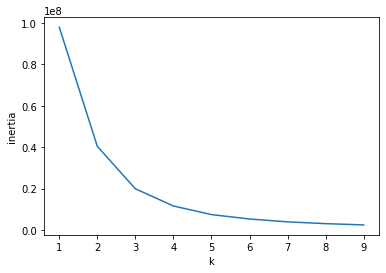

In [113]:
X = df.drop(columns=['author', "num_posts", "num_days"])
inertia = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)

elbow_data = {"k": range(1, 10), "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
plt.plot(df_elbow.k, df_elbow.inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

In [114]:
def get_clusters(k, data):
    x = data.drop(columns=['author', "num_posts", "num_days"])
    X_scaled = StandardScaler().fit_transform(x)
    model= KMeans(n_clusters=k, random_state=0).fit(X_scaled)

    predictions = model.predict(x)
    data["class"] = model.labels_
    return data, predictions, model

In [115]:
ml_trained_data, ml_predictions, ml_model = get_clusters(3, df)

C:\Users\steve\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


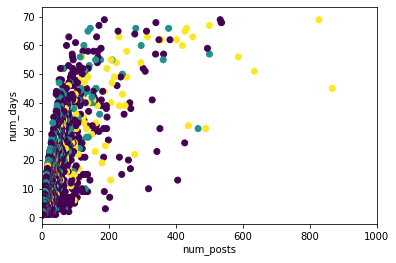

In [116]:
plt.scatter(df["num_posts"], df["num_days"], c=df["class"])
plt.xlabel("num_posts")
plt.ylabel("num_days")
#limit the x and y axis to the range of the data
plt.xlim(0,1000)
plt.show()

In [117]:
df["class"].value_counts()

0    28116
1    15458
2     1317
Name: class, dtype: int64

In [118]:
df.sort_values(by=["class", "num_posts"], ascending=[False, False]).head(15)

,author,benshapiro_ppd,conspiracy_ppd,conservative_ppd,conservatives_ppd,conspiracy_ppd,economy_ppd,liberal_ppd,politics_ppd,republican_ppd,republicans_ppd,worldnews_ppd,Cross-Posts,Avg Post Length,num_posts,num_days,class
0,saurin212,2.813,4.895,21.714,11.692,0.000,5.667,0.000,0.00,13.788,11.389,0.000,2.36,79.28,3194,70,2
1,[deleted],1.167,0.000,5.493,1.182,3.839,1.714,1.143,4.75,1.263,1.000,19.203,1.05,80.70,2320,70,2
2,NavyCorpsmanRetiree,0.000,0.000,15.793,34.548,0.000,0.000,0.000,0.00,2.000,0.000,0.000,1.37,70.00,1531,31,2
3,nimobo,0.000,0.000,21.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,1.02,80.94,1428,68,2
4,evaldez14,0.000,0.000,8.868,8.870,1.333,0.000,0.000,1.00,0.000,0.000,0.000,1.87,88.73,1220,69,2
5,Texas_4R,0.000,0.000,22.622,1.000,0.000,0.000,0.000,0.00,4.167,0.000,6.857,1.01,74.29,1096,45,2
6,xsader_4C,0.000,0.000,16.432,0.000,0.000,0.000,0.000,0.00,2.833,0.000,2.867,1.04,82.81,868,45,2
7,mjprice83,3.899,0.000,4.116,3.986,0.000,0.000,0.000,0.00,0.000,0.000,0.000,2.72,77.33,828,69,2
8,Nopedontcarez,0.000,0.000,0.000,5.196,0.000,0.000,0.000,0.00,6.188,5.420,0.000,2.20,76.74,635,51,2
9,intelligentreviews,0.000,0.000,3.589,4.405,0.000,0.000,0.000,0.00,4.208,0.000,0.000,2.07,76.83,587,56,2


In [119]:
clustered_df = df[["author", "class"]]

In [120]:
for i in range(len(clustered_df)):
    author = clustered_df.iloc[i]["author"]
    class_num = clustered_df.iloc[i]["class"].astype(object)
    sql = """INSERT INTO author_classes (author, class_num) VALUES (%s, %s)"""
    data = (author, class_num)
    cur = conn.cursor()
    cur.execute(sql, data)
    conn.commit()